# Imports

In [27]:
# Basic imports
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

# Plotting and animations
import cartopy 
import cartopy.crs as ccrs
import math
import ipywidgets as widgets
import datetime
from IPython.display import HTML
from matplotlib import animation
from typing import Optional

# Model
from UNet import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Reshape

import torch

In [15]:
ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = xr.open_dataset('ERA5_Data/2023_SouthAfrica.nc')
# ds = ds.sel(expver=1).combine_first(ds.sel(expver=5))
ds.load()

ds['ws'] = (ds.u10**2 + ds.v10**2)**0.5

# Data Check

In [16]:
def select(
    data: xr.Dataset,
    variable: str,
    level: Optional[int] = None,
    max_steps: Optional[int] = None
    ) -> xr.Dataset:
  data = data[variable]
  # if "batch" in data.dims:
  #   data = data.isel(batch=0)
  if max_steps is not None and "time" in data.sizes and max_steps < data.sizes["time"]:
    data = data.isel(time=range(0, max_steps))
  # if level is not None and "level" in data.coords:
  #   data = data.sel(level=level)
  return data

def scale(
    data: xr.Dataset,
    center: Optional[float] = None,
    robust: bool = False,
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:
  vmin = np.nanpercentile(data, (2 if robust else 0))
  vmax = np.nanpercentile(data, (98 if robust else 100))
  if center is not None:
    diff = max(vmax - center, center - vmin)
    vmin = center - diff
    vmax = center + diff
  return (data, matplotlib.colors.Normalize(vmin, vmax),
          ("RdBu_r" if center is not None else "viridis"))

def plot_data(
    data: dict[str, xr.Dataset],
    fig_title: str,
    plot_size: float = 5,
    robust: bool = False,
    cols: int = 4
    ) -> tuple[xr.Dataset, matplotlib.colors.Normalize, str]:

  first_data = next(iter(data.values()))[0]
  max_steps = first_data.sizes.get("time", 1)
  assert all(max_steps == d.sizes.get("time", 1) for d, _, _ in data.values())

  cols = min(cols, len(data))
  rows = math.ceil(len(data) / cols)

  figure = plt.figure(figsize=(plot_size * 2 * cols,
                               plot_size * rows))
  figure.suptitle(fig_title, fontsize=16)
  figure.subplots_adjust(wspace=0, hspace=0)
  figure.tight_layout()
  
  images = []
  for i, (title, (plot_data, norm, cmap)) in enumerate(data.items()):
    ax = figure.add_subplot(rows, cols, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(title)
    im = ax.imshow(
        plot_data.isel(time=0, missing_dims="ignore"), norm=norm,
        origin="lower", cmap=cmap)
    plt.colorbar(
        mappable=im,
        ax=ax,
        orientation="vertical",
        pad=0.02,
        aspect=16,
        shrink=0.75,
        cmap=cmap,
        extend=("both" if robust else "neither"))
    images.append(im)

  def update(frame):
      reference_date = datetime.datetime(1970, 1, 1)
      if "time" in first_data.dims:
        td = datetime.timedelta(microseconds=first_data["time"][frame].item() / 1000)
        td = reference_date + td
        figure.suptitle(f"{fig_title}, {td.strftime('%Y-%m-%d %H:%M:%S')}", fontsize=16)
      else:
        figure.suptitle(fig_title, fontsize=16)
      for im, (plot_data, norm, cmap) in zip(images, data.values()):
        im.set_data(plot_data.isel(time=frame, missing_dims="ignore"))

  ani = animation.FuncAnimation(
      fig=figure, func=update, frames=max_steps, interval=250)
  plt.close(figure.number)
  return HTML(ani.to_jshtml())

plot_size = 7
level = 1000

variable = 'ws'

data = {
    " ": scale(select(ds, variable, level, max_steps=5),
              robust=True),
}

fig_title = 'Wind Speed'

plot_data(data, fig_title, plot_size, robust=True)

# Data Preperation

In [33]:
# @title Data Preperation

window_size = 3
variable = 'ws'

X, y = [], []

for i in range(ds.time.size - window_size):
    X.append(ds[variable].isel(time=slice(i, i + window_size)))
    y.append(ds[variable].isel(time=i + window_size))

X_ = np.array(X) 
y_ = np.array(y)

# Train Validation Split
split = round(X_.shape[0] * 0.9)

# Shape fixing
# lon_shape = ds.longitude.size
# lat_shape = ds.latitude.size

# Custom Shapes for the data
lon_shape = 64
lat_shape = 32
X_ = X_[:,:, 1:33, 3:67]
y_ = y_[:,1:33,3:67]

# Normalization
max_ws = X_.max()
X_n = X_ / max_ws
y_n = y_ / max_ws

# Splitting
f_train, t_train = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_test, t_test = X_n[split:].astype('float32'), y_n[split:].astype('float32')
print('Train Shape: ', f_train.shape, t_train.shape, '\n\nTest Shape: ', f_test.shape, t_test.shape)

X_n = X_n.reshape(-1, lat_shape, lon_shape, window_size)
y_n = y_n.reshape(-1, lat_shape, lon_shape,  1)

f_training, t_training = X_n[:split].astype('float32'), y_n[:split].astype('float32')
f_testing, t_testing = X_n[split:].astype('float32'), y_n[split:].astype('float32')

Train Shape:  (7881, 3, 32, 64) (7881, 32, 64) 

Test Shape:  (876, 3, 32, 64) (876, 32, 64)


# Build Model

In [29]:
# @title Custom Build Model

def build_unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    # s3, p3 = encoder_block(p2, 256)
    # s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p2, 256) #Bridge

    # d1 = decoder_block(b1, s4, 512)
    # d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(b1, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)  
    
    model = Model(inputs, outputs, name="U-Net")
    return model

In [30]:
input_shape = tuple((1, lat_shape, lon_shape, window_size))
plot_shape = t_training[0].shape
output_shape = t_train.shape[1:] 

kernel_size = (1, 3)
pool_size = (2,2)
model = build_unet(input_shape[1:])
model.summary()  

# print(model.predict(f_train[0:1].reshape(input_shape)).shape)  

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 32, 64, 3)]          0         []                            
                                                                                                  
 conv2d_72 (Conv2D)          (None, 32, 64, 64)           1792      ['input_6[0][0]']             
                                                                                                  
 batch_normalization_68 (Ba  (None, 32, 64, 64)           256       ['conv2d_72[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_68 (Activation)  (None, 32, 64, 64)           0         ['batch_normalization_68[0

In [31]:
batch_size = 128
epochs = 500
model.compile(optimizer='adam', loss='mse')

In [32]:
early_stopping = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('weather_model.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')

# Train model in Google Colab

if True:
    history = model.fit(
        f_training, 
        t_training, 
        batch_size=batch_size, 
        epochs=epochs, 
        verbose=1, 
        validation_data=(f_testing, t_testing),
        callbacks=[early_stopping, model_checkpoint]
    )

else:
    model.load_weights('models/best_model_synth_3_16_48.h5')

TypeError: Cannot convert the argument `type_value`: torch.float32 to a TensorFlow DType.

In [24]:
def plot_state(state, prediction=None, target=None):
    add = 0
    if prediction is not None:
        add += 1
    if target is not None:
        add += 1
    fig, ax = plt.subplots(1, state.shape[0] + add, figsize=(20, 5))
    for i in range(state.shape[0]):
        ax[i].imshow(state[i])
        ax[i].set_title(f'Input {i}')
        plt.colorbar(ax[i].imshow(state[i]), ax=ax[i])

    if prediction is not None:
        ax[state.shape[0]].imshow(prediction)
        ax[state.shape[0]].set_title('Prediction')
        plt.colorbar(ax[state.shape[0]].imshow(prediction), ax=ax[state.shape[0]])
                     
    if target is not None:
        ax[state.shape[0] -1 + add].imshow(target)
        ax[state.shape[0] -1 + add].set_title('Target')
        plt.colorbar(ax[state.shape[0] - 1 + add].imshow(target), ax=ax[state.shape[0] -1 + add])

    plt.show()

1/1 [==============================] - 0s 28ms/step


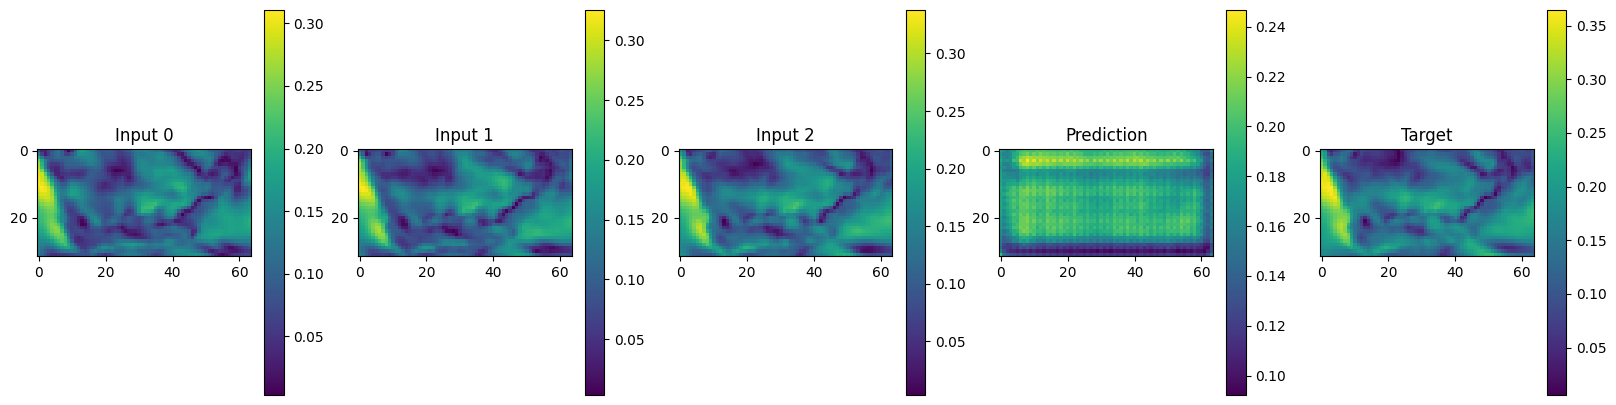

1/1 [==============================] - 0s 38ms/step


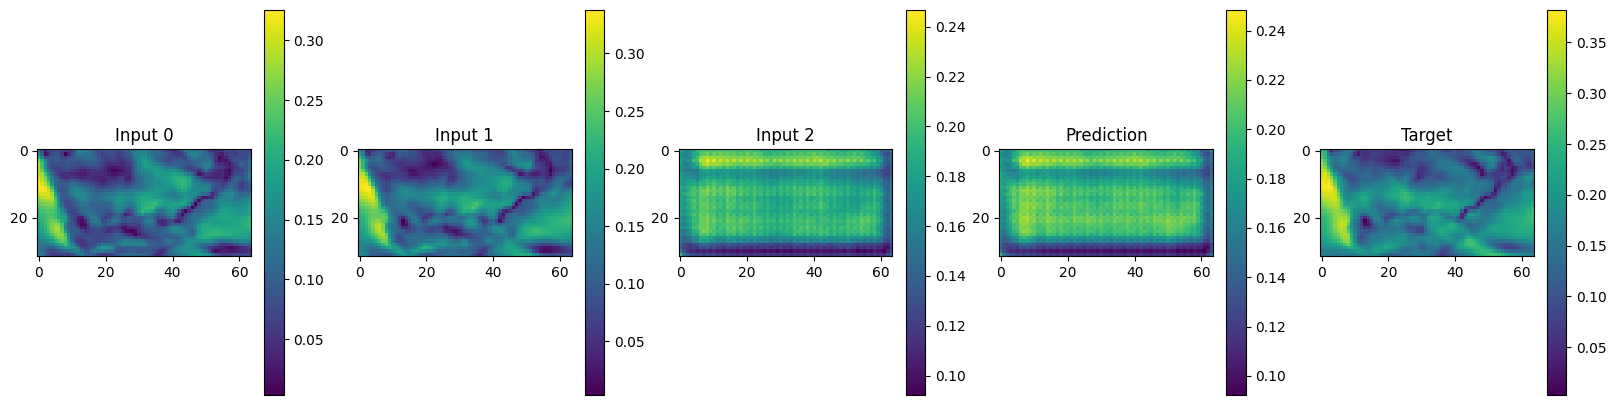

1/1 [==============================] - 0s 33ms/step


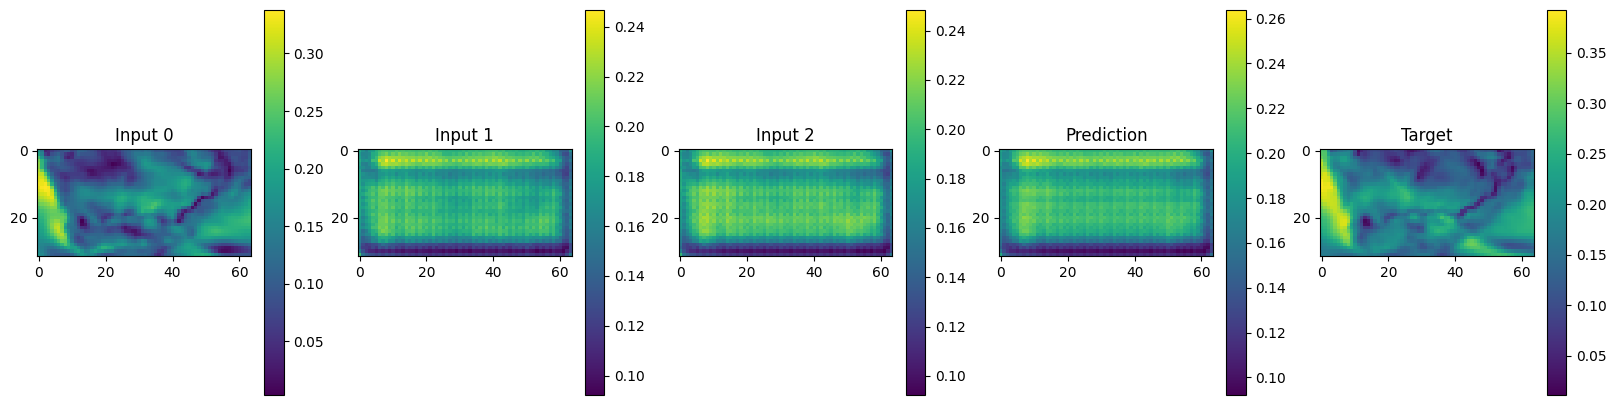

1/1 [==============================] - 0s 28ms/step


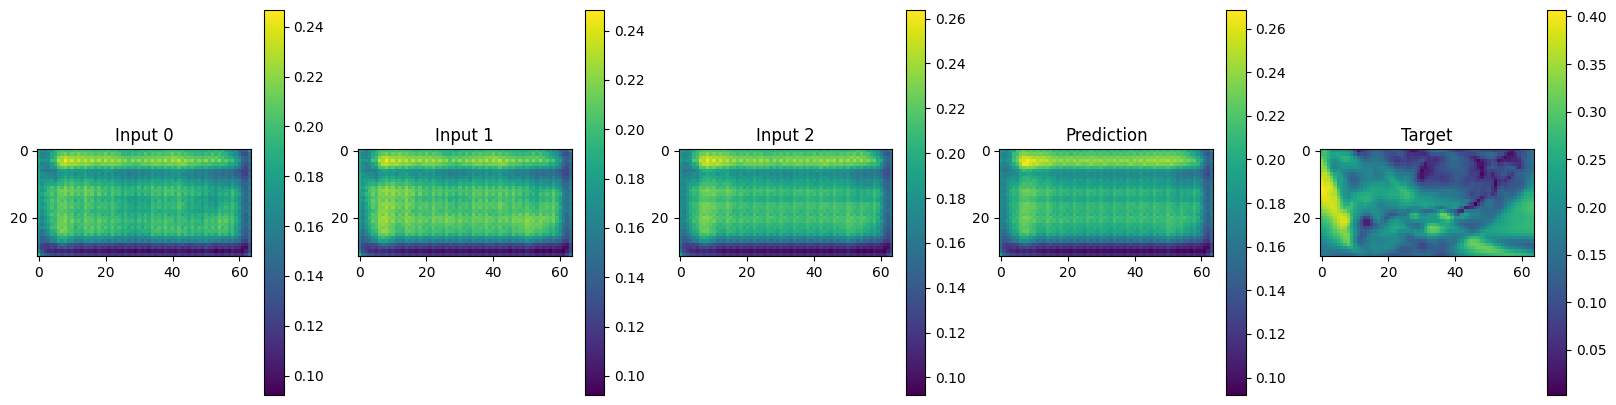

1/1 [==============================] - 0s 34ms/step


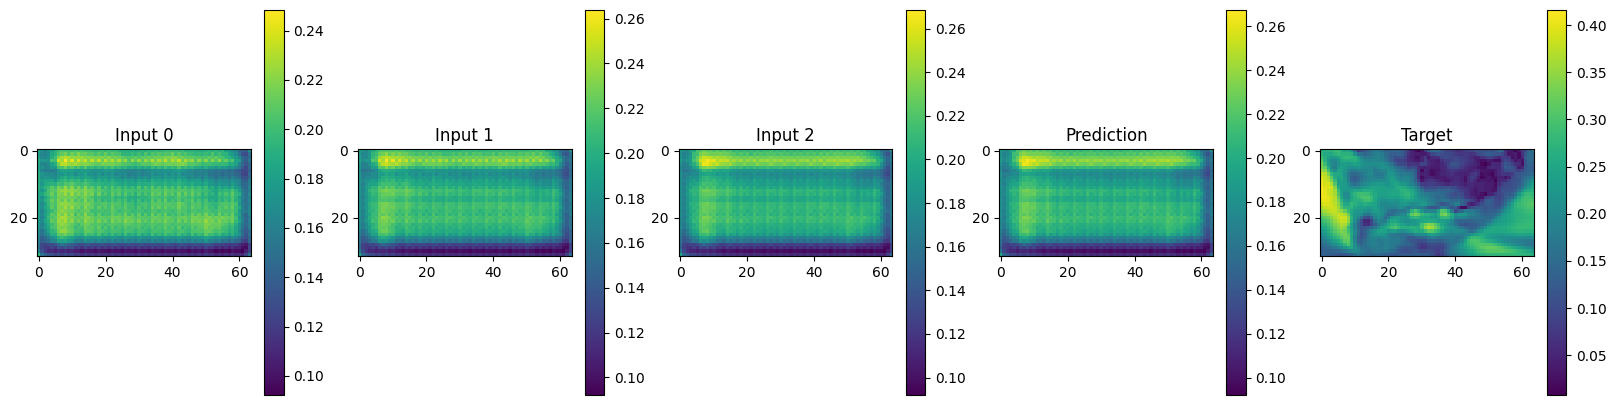

1/1 [==============================] - 0s 117ms/step


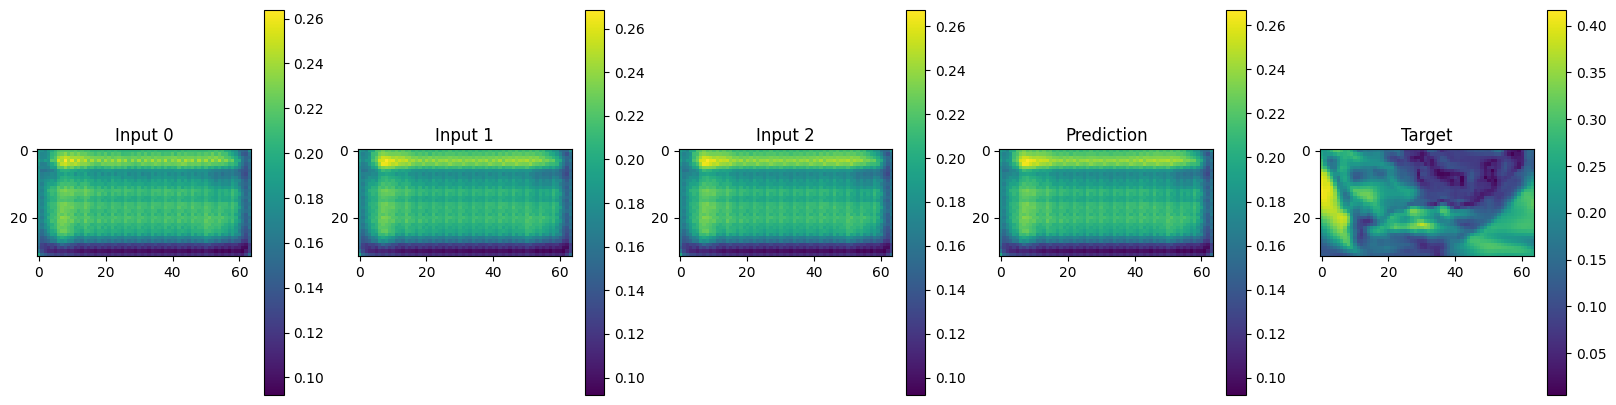

1/1 [==============================] - 0s 36ms/step


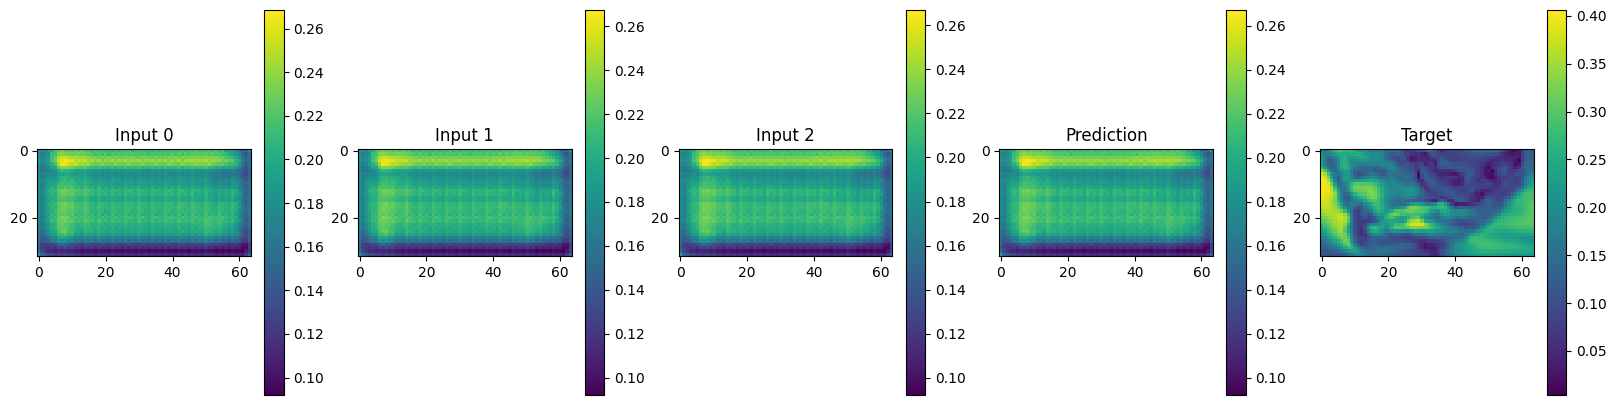

1/1 [==============================] - 0s 94ms/step


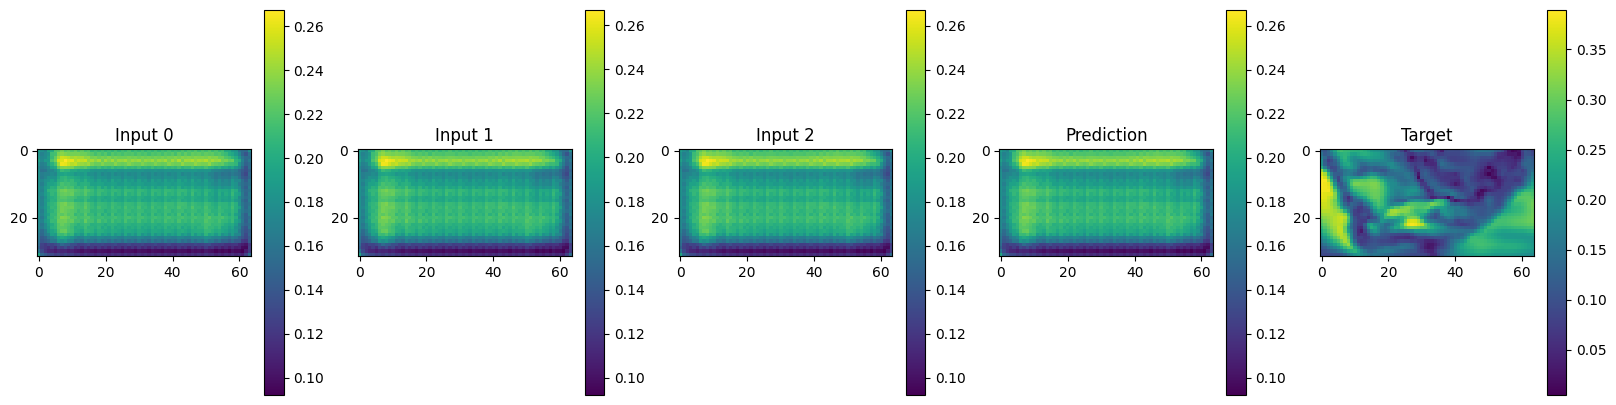

1/1 [==============================] - 0s 62ms/step


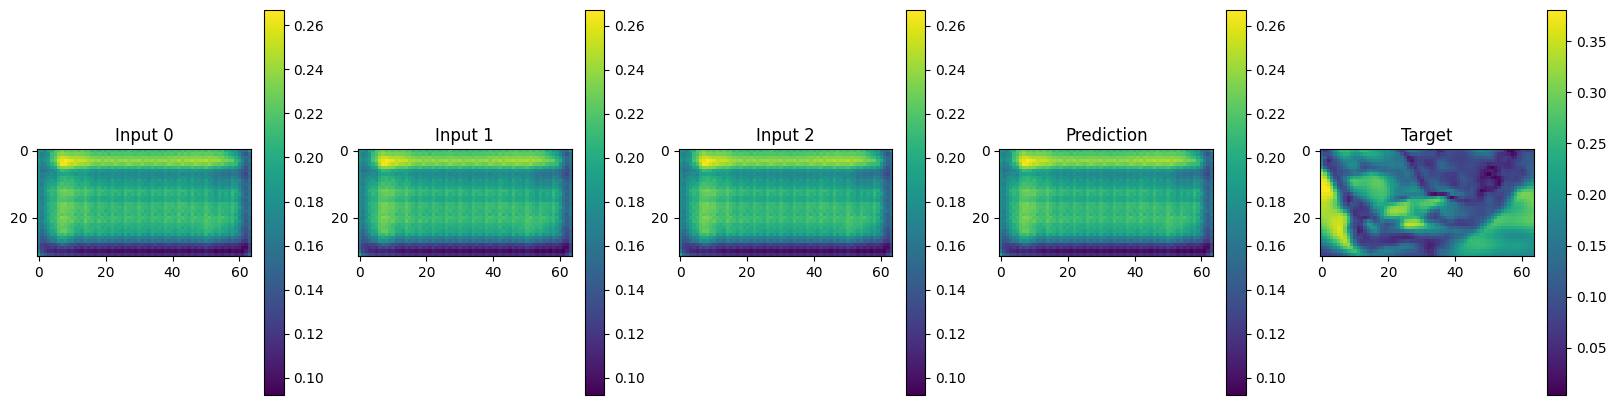

1/1 [==============================] - 0s 43ms/step


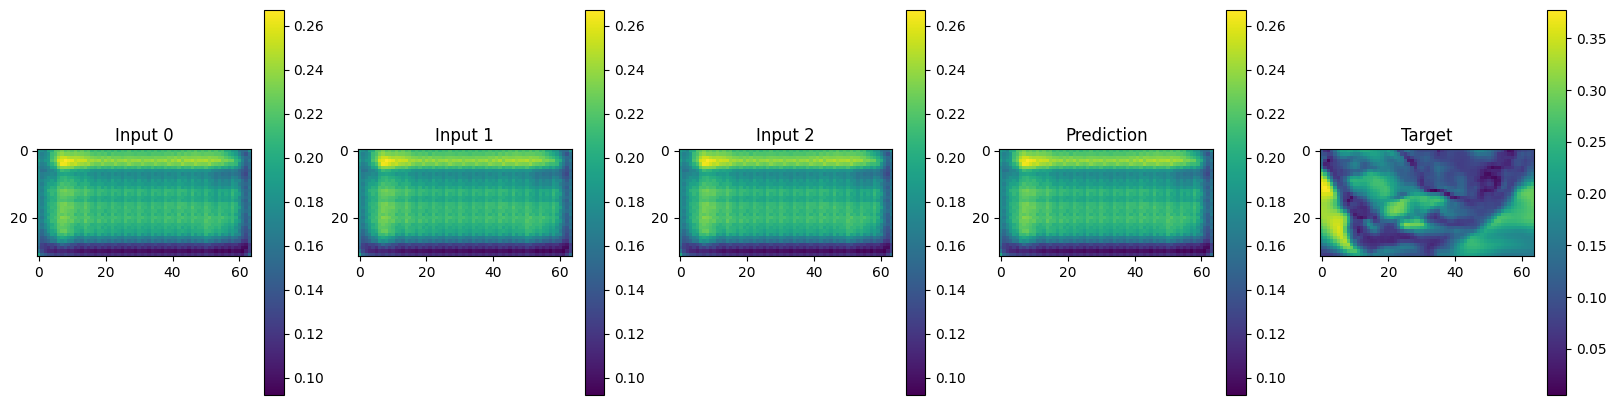

1/1 [==============================] - 0s 36ms/step


In [26]:
model.load_weights('weather_model.h5')

current_state = f_test[0:1]

pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)

for i in range(10):
    plot_state(current_state[0], prediction=pred, target=t_test[i])
    current_state = current_state[:,1:]
    current_state = np.append(current_state, pred.reshape(1, 1, pred.shape[0], pred.shape[1]), axis=1)

    pred = model.predict(current_state.reshape(input_shape)).reshape(plot_shape)

